# Project Akhir Klasifikasi Gambar 

* **Nama:** Junpito Salim
* **Email:** Junpitosalim@gmail.com

# 1 | Import library

In [1]:
import zipfile
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
from skimage import io
import cv2
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage import img_as_ubyte
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from PIL import Image

2024-09-11 05:31:25.099994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 05:31:25.100066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 05:31:25.101553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.15.1


In [3]:
#!pip uninstall -y tensorflow
#!pip install tensorflow==2.15.1

# 2 | Load Dataset

In [4]:
dataset_path = '/kaggle/input/animals10/raw-img'

## 2.1 | Hitung Jumlah Gambar dalam Dataset

In [5]:
from pathlib import Path

# Hitung jumlah file dalam path dataset
file_count = len(list(Path(dataset_path).rglob('*')))

# Tampilkan jumlah file
print(f"Jumlah file dalam path {dataset_path}: {file_count}")

Jumlah file dalam path /kaggle/input/animals10/raw-img: 26189


## 2.2 | Sebaran Resolusi Gambar dalam Dataset

In [6]:
# Inisialisasi list untuk menyimpan resolusi
image_resolutions = []

# Loop melalui semua folder dan file di dalam dataset_path
for subdir, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(subdir, file)
        
        # Memastikan hanya file gambar yang diambil
        try:
            with Image.open(file_path) as img:
                width, height = img.size
                image_resolutions.append((width, height))
        except:
            # Lewatkan file yang bukan gambar
            continue


In [7]:
# Memisahkan width dan height untuk visualisasi
widths = [w for w, h in image_resolutions]
heights = [h for w, h in image_resolutions]

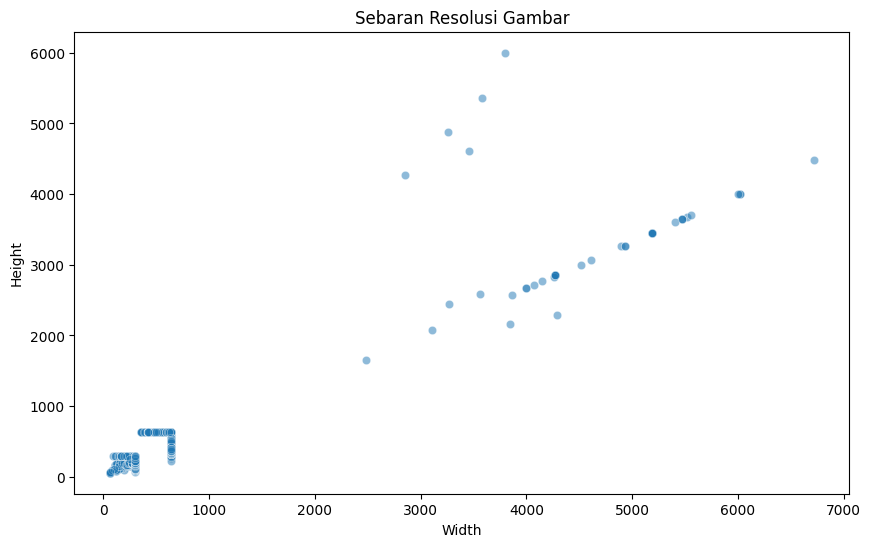

In [8]:
# Visualisasi sebaran resolusi dengan seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=widths, y=heights, alpha=0.5)
plt.title('Sebaran Resolusi Gambar')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

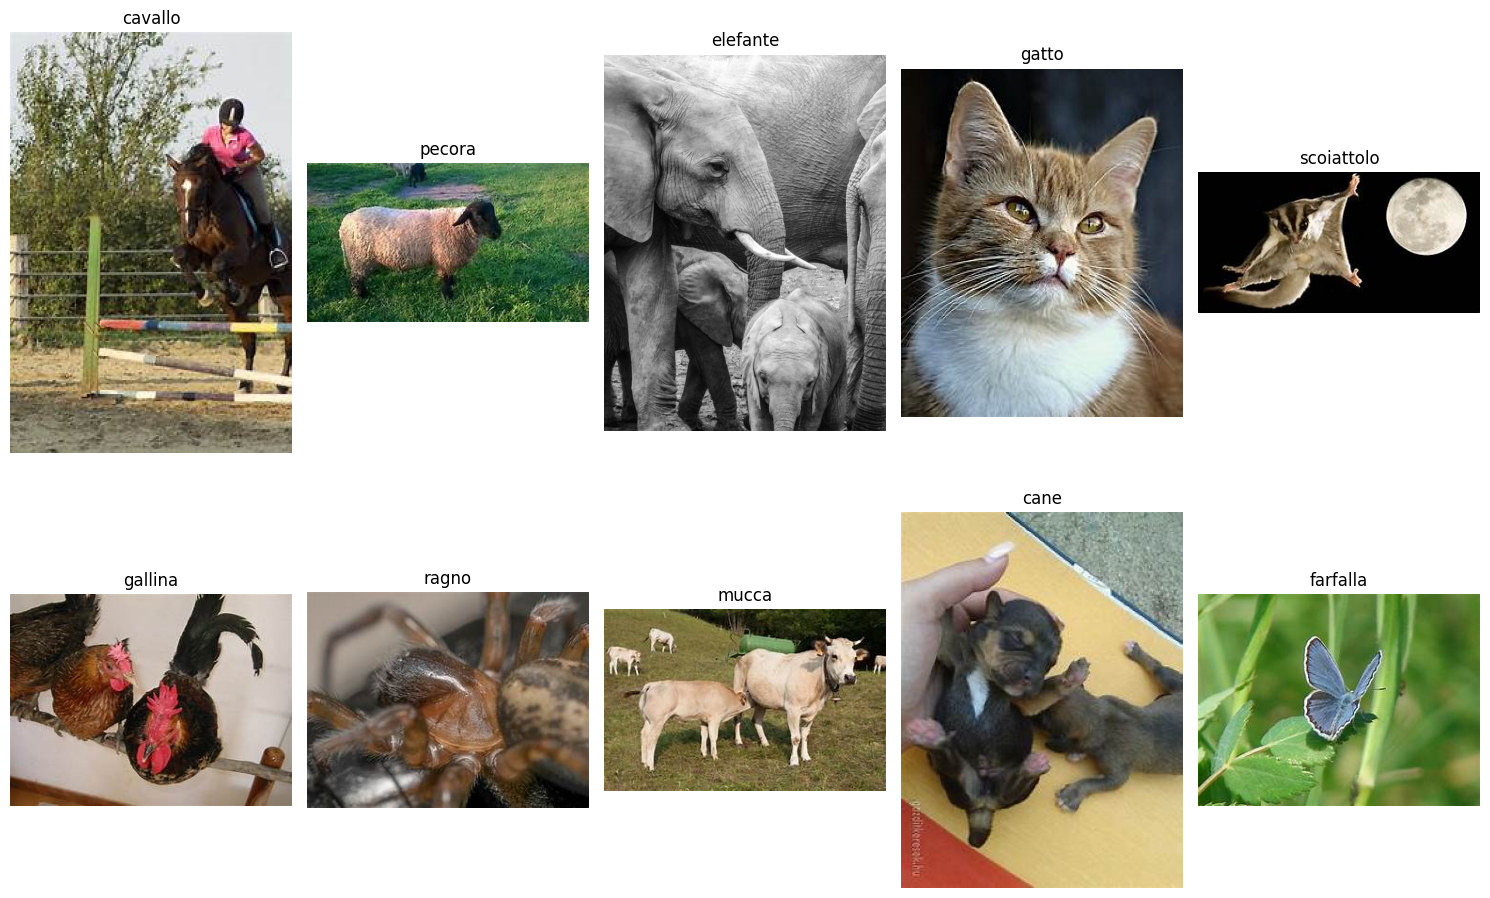

In [9]:
# Fungsi untuk menampilkan gambar dari setiap label
def show_sample_images_from_labels(dataset_path):
    # Dapatkan semua folder (label) di dataset_path
    labels = [label for label in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, label))]
    
    # Atur plot grid (misal, 3x3 untuk menampilkan 9 gambar jika ada lebih dari 9 label)
    num_labels = len(labels)
    num_cols = 5
    num_rows = (num_labels // num_cols) + 1 if num_labels % num_cols != 0 else num_labels // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, label in enumerate(labels):
        # Dapatkan semua file gambar dalam folder label
        label_path = os.path.join(dataset_path, label)
        images = os.listdir(label_path)
        
        # Pilih satu gambar secara acak
        random_image = random.choice(images)
        image_path = os.path.join(label_path, random_image)
        
        # Buka gambar dan tampilkan
        img = Image.open(image_path)
        
        # Plot gambar di grid
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')  # Hilangkan sumbu koordinat

    plt.tight_layout()
    plt.show()
    
# Panggil fungsi untuk menampilkan gambar sample
show_sample_images_from_labels(dataset_path)

# 3 | Preprocessing

## 3.1 | Split Dataset dan Augmentasi Data

In [10]:
# Parameter
img_height, img_width = 224, 224 
batch_size = 128
split = 0.2 # 20% data untuk validasi

In [11]:
# Data augmentation dengan ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi piksel
    validation_split=split
)

In [31]:
# Data generator untuk training
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes=['cavallo','pecora','elefante','gatto','scoiattolo','galina','ragno','mucca','cane','farfalla'],
    class_mode='categorical',
    subset='training'  # Subset untuk data latih
)

# Data generator untuk validation
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes=['cavallo','pecora','elefante','gatto','scoiattolo','galina','ragno','mucca','cane','farfalla'],
    class_mode='categorical',
    subset='validation'  # Subset untuk data validasi
)

Found 18468 images belonging to 10 classes.
Found 4613 images belonging to 10 classes.


# 4 | Pembuatan Model CNN

In [32]:
from tensorflow.keras.applications import MobileNet, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Load DenseNet121 without top layers
base_model = DenseNet121(weights='imagenet', include_top=False
                         , input_shape=(224, 224, 3))
base_model.trainable = False

# Build the model
model = Sequential()
model.add(base_model)

# Add more layers after DenseNet121
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Now build the model
model.build((None, 224, 224, 3))

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          294944    
                                                                 
 batch_normalization_1 (Bat  (None, 5, 5, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

# 5 | Pelatihan Model 

## 5.1 | Latih model menggunakan callbacks 


In [33]:
learning_rate= 0.001 #kita gunakan default
optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-2) 
epoch = 100

In [34]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Defenisikan early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Defenisikan model checkpoint callback untuk menyimpan model terbaik selama pelatihan
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Defeniskan learning rate reduction callback untuk mengatur lr secara otomatis
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)


# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
history = model.fit(train_generator, epochs = epoch, validation_data= val_generator,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping])

Epoch 1/100
145/145 [==============================] - 93s 594ms/step - loss: 0.3012 - accuracy: 0.9117 - val_loss: 0.1651 - val_accuracy: 0.9504 - lr: 0.0100
Epoch 2/100
145/145 [==============================] - 73s 503ms/step - loss: 0.1552 - accuracy: 0.9523 - val_loss: 0.1501 - val_accuracy: 0.9551 - lr: 0.0100
Epoch 3/100
145/145 [==============================] - 71s 488ms/step - loss: 0.1289 - accuracy: 0.9630 - val_loss: 0.2276 - val_accuracy: 0.9501 - lr: 0.0100
Epoch 4/100
145/145 [==============================] - 75s 520ms/step - loss: 0.1115 - accuracy: 0.9649 - val_loss: 0.1455 - val_accuracy: 0.9599 - lr: 0.0100
Epoch 5/100
145/145 [==============================] - 72s 494ms/step - loss: 0.0895 - accuracy: 0.9732 - val_loss: 0.1970 - val_accuracy: 0.9471 - lr: 0.0100
Epoch 6/100
145/145 [==============================] - 72s 492ms/step - loss: 0.0772 - accuracy: 0.9755 - val_loss: 0.1870 - val_accuracy: 0.9547 - lr: 0.0100
Epoch 7/100
145/145 [=========================

## 5.2 Plot Pelatihan

Plot saved to loss_plot.png


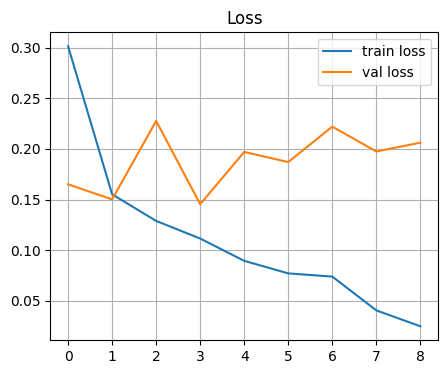

In [38]:
import matplotlib.pyplot as plt

def plot_history(history, save_path="loss_plot.png"):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(history.history["loss"], label="train loss")
    ax.plot(history.history["val_loss"], label="val loss")
    ax.set_title("Loss")
    ax.legend()
    ax.grid()
    
    # Simpan plot ke file PNG dengan path default
    plt.savefig(save_path, format='png', dpi=300)
    print(f"Plot saved to {save_path}")
    
    # Tampilkan plot
    plt.show()
    

plot_history(history)

Plot saved to accuracy_plot.png


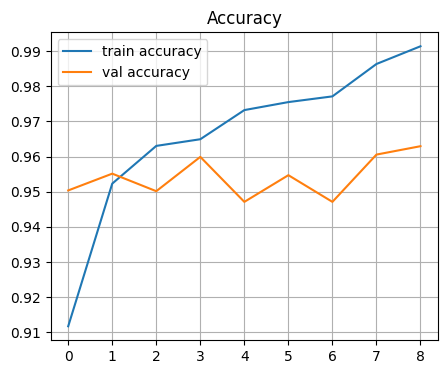

In [39]:
def plot_history(history, save_path="accuracy_plot.png"):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(history.history["accuracy"], label="train accuracy")
    ax.plot(history.history["val_accuracy"], label="val accuracy")
    ax.set_title("Accuracy")
    ax.legend()
    ax.grid()
    
    # Simpan plot ke file PNG dengan path default
    plt.savefig(save_path, format='png', dpi=300)
    print(f"Plot saved to {save_path}")
    
    # Tampilkan plot
    plt.show()
    

plot_history(history)

# 6 | Menyimpan Model

In [40]:
model.load_weights('/kaggle/working/best_model.keras')

In [41]:
# Define working directory and saved model directory
work_dir = '/kaggle/working/'
saved_model_dir = os.path.join(work_dir, 'saved_model')

# Create the directory if it doesn't exist
os.makedirs(saved_model_dir, exist_ok=True)

# Save the model in SavedModel format
tf.saved_model.save(model, saved_model_dir)

## 6.1 | TF-Lite

In [42]:
import tensorflow as tf 

# Convert the SavedModel to TFLite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = os.path.join(work_dir, 'best_model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 318, Total Ops 637, % non-converted = 49.92 %
 * 318 ARITH ops

- arith.constant:  318 occurrences  (f32: 315, i32: 3)



  (f32: 63)
  (f32: 3)
  (f32: 58)
  (f32: 121)
  (f32: 2)
  (f32: 2)
  (f32: 63)
  (f32: 2)
  (f32: 1)
  (f32: 1)


TFLite model saved at: /kaggle/working/best_model.tflite


## 6.2 | TFJS

In [43]:
pip install tensorflowjs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [44]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /kaggle/working/saved_model /kaggle/working/tfjs_model


2024-09-11 07:03:51.456085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 07:03:51.482469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 07:03:51.482536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 7.2 | Inference Testing

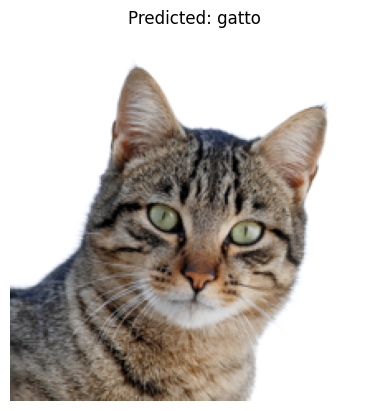

In [50]:
# Load kelas 
class_names = ['cavallo','pecora','elefante','gatto','scoiattolo','galina','ragno','mucca','cane','farfalla']

# Load model TFLite
tflite_model_path = '/kaggle/working/best_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

# Allocate tensors
interpreter.allocate_tensors()

# Mendapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load image 
image_path = '/kaggle/input/test-datset/kucing2.jpeg'  
img = Image.open(image_path).resize((224, 224))  # Resize sesuai kebutuhan model

# Preprocessing gambar 
img_array = np.array(img, dtype=np.float32) / 255.0  # Normalisasi
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)

# Jalankan inference
interpreter.invoke()

# Ambil hasil dari output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class_idx = np.argmax(output_data)

# Ambil nama kelas berdasarkan hasil prediksi
predicted_class_name = class_names[predicted_class_idx]

# Menampilkan gambar dan prediksi
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')  # Hapus axis untuk visualisasi yang lebih jelas
plt.show()